# CS156: Silksong Watch Controller - Machine Learning Pipeline

**Phase III: From Raw Sensor Data to Gesture Classification Model**

---

## Overview

This notebook documents the complete machine learning pipeline for transforming raw IMU sensor data from a smartwatch into a functional gesture recognition system for controlling Hollow Knight/Silksong.

**Pipeline Stages:**
1. **Data Loading & Exploration** - Understanding the raw sensor data
2. **Feature Engineering** - Extracting meaningful features from time-series data
3. **Model Training** - Training and evaluating classification models
4. **Model Serialization** - Saving models for deployment
5. **Validation** - Testing model performance

**Model Choice:** Support Vector Machine (SVM) with RBF kernel
- Mathematical rigor and explainability
- Strong performance on high-dimensional feature spaces
- Efficient for real-time prediction

---

## 1. Environment Setup

Import required libraries and configure notebook settings.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import glob
import os
import json
from collections import Counter

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score
)

# Signal processing
from scipy import stats
from scipy.fft import fft

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ Environment setup complete")
print(f"  Python: {pd.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")

✓ Environment setup complete
  Python: 2.3.3
  Pandas: 2.3.3
  NumPy: 2.3.3


## 2. Data Loading & Exploration

### 2.1 Understanding the Data Format

**Data Structure:**
```
training_data/
└── session_YYYYMMDD_HHMMSS/
    ├── gesture_name_sample01.csv
    ├── gesture_name_sample02.csv
    └── ...
```

**CSV Format:**
- `timestamp`: Time in seconds (0.000 to 3.000)
- `sensor`: Type (rotation_vector, linear_acceleration, gyroscope)
- `gesture`: Gesture label
- `stance`: Physical stance (combat, neutral, travel)
- `sample`: Sample number (1-5)
- Sensor-specific columns: rot_x/y/z/w, accel_x/y/z, gyro_x/y/z

**Sensors Used:**
1. **Linear Acceleration** - Linear movement (gravity removed)
2. **Gyroscope** - Angular velocity
3. **Rotation Vector** - Orientation (quaternion)

In [2]:
def load_session_data(session_dir):
    """Load all CSV files from a data collection session.

    Parameters:
    -----------
    session_dir : str
        Path to session directory containing CSV files

    Returns:
    --------
    pd.DataFrame
        Combined dataframe with all recordings from the session
    """
    csv_files = glob.glob(os.path.join(session_dir, "*.csv"))

    if not csv_files:
        print(f"⚠️  No CSV files found in {session_dir}")
        return pd.DataFrame()

    data_frames = []
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            # Add source filename for tracking
            df["source_file"] = os.path.basename(csv_file)
            data_frames.append(df)
        except Exception as e:
            print(f"⚠️  Error loading {csv_file}: {e}")

    if not data_frames:
        return pd.DataFrame()

    # Combine all recordings
    combined = pd.concat(data_frames, ignore_index=True)
    return combined


def load_all_training_data(base_dir="training_data"):
    """Load training data from all sessions.

    Parameters:
    -----------
    base_dir : str
        Base directory containing session folders

    Returns:
    --------
    pd.DataFrame
        Combined dataframe with all training data
    """
    if not os.path.exists(base_dir):
        print(f"❌ Training data directory not found: {base_dir}")
        print("\nPlease run the data collection script first:")
        print("  python src/data_collector.py")
        return pd.DataFrame()

    session_dirs = glob.glob(os.path.join(base_dir, "session_*"))

    if not session_dirs:
        print(f"❌ No session directories found in {base_dir}")
        return pd.DataFrame()

    print(f"📁 Found {len(session_dirs)} session(s)")

    all_sessions = []
    for session_dir in sorted(session_dirs):
        session_name = os.path.basename(session_dir)
        print(f"  Loading {session_name}...")

        session_data = load_session_data(session_dir)
        if not session_data.empty:
            session_data["session"] = session_name
            all_sessions.append(session_data)

    if not all_sessions:
        print("❌ No data loaded from any session")
        return pd.DataFrame()

    # Combine all sessions
    all_data = pd.concat(all_sessions, ignore_index=True)

    print(f"\n✓ Loaded {len(all_data):,} sensor readings")
    return all_data

In [3]:
# Load all training data
print("=" * 60)
print("LOADING TRAINING DATA")
print("=" * 60)

all_data = load_all_training_data()

if all_data.empty:
    print("\n⚠️  No training data available. Cannot proceed with model training.")
    print("\nNext Steps:")
    print("1. Run the data collection script: python src/data_collector.py")
    print("2. Follow the guided procedure to collect gesture data")
    print("3. Re-run this notebook after data collection")
else:
    print("\n✓ Data loaded successfully!")

LOADING TRAINING DATA
📁 Found 1 session(s)
  Loading session_20251014_201836...

✓ Loaded 88,296 sensor readings

✓ Data loaded successfully!


### 2.2 Data Exploration

In [4]:
# Only proceed if data was loaded
if not all_data.empty:
    print("=" * 60)
    print("DATA SUMMARY")
    print("=" * 60)

    print(f"\nDataset Shape: {all_data.shape}")
    print(f"  Rows (sensor readings): {all_data.shape[0]:,}")
    print(f"  Columns: {all_data.shape[1]}")

    print("\n--- Gestures ---")
    gesture_counts = (
        all_data.groupby("gesture")["sample"].nunique().sort_values(ascending=False)
    )
    print(f"Unique gestures: {len(gesture_counts)}")
    for gesture, count in gesture_counts.items():
        print(f"  {gesture}: {count} samples")

    print("\n--- Sensors ---")
    sensor_counts = all_data["sensor"].value_counts()
    for sensor, count in sensor_counts.items():
        print(f"  {sensor}: {count:,} readings")

    print("\n--- Stances ---")
    stance_counts = all_data["stance"].value_counts()
    for stance, count in stance_counts.items():
        print(f"  {stance}: {count:,} readings")

    print("\n--- Data Quality ---")
    missing_data = all_data.isnull().sum()
    if missing_data.sum() > 0:
        print("Missing values detected:")
        print(missing_data[missing_data > 0])
    else:
        print("No missing values in metadata columns")

    # Display first few rows
    print("\n--- Sample Data ---")
    display(all_data.head(10))

DATA SUMMARY

Dataset Shape: (88296, 18)
  Rows (sensor readings): 88,296
  Columns: 18

--- Gestures ---
Unique gestures: 5
  noise: 80 samples
  jump: 40 samples
  punch: 40 samples
  turn: 40 samples
  walk: 0 samples

--- Sensors ---
  gyroscope: 29,462 readings
  linear_acceleration: 29,453 readings
  rotation_vector: 29,381 readings

--- Stances ---
  travel: 39,614 readings
  neutral: 32,892 readings
  combat: 15,790 readings

--- Data Quality ---
Missing values detected:
accel_x            58843
accel_y            58843
accel_z            58843
gyro_x             58834
gyro_y             58834
gyro_z             58834
rot_w              58915
rot_x              58915
rot_y              58915
rot_z              58915
sample             22371
collection_mode    65925
dtype: int64

--- Sample Data ---


,accel_x,accel_y,accel_z,gesture,gyro_x,gyro_y,gyro_z,rot_w,rot_x,rot_y,rot_z,sample,sensor,stance,timestamp,source_file,collection_mode,session
0,NaN,NaN,NaN,punch,NaN,NaN,NaN,0.5734,-0.5243,0.0315,-0.6288,22.0000,rotation_vector,combat,0.0241,punch_sample22.csv,NaN,session_20251014_201836
1,NaN,NaN,NaN,punch,-0.3271,-0.2306,-1.5020,NaN,NaN,NaN,NaN,22.0000,gyroscope,combat,0.0256,punch_sample22.csv,NaN,session_20251014_201836
2,0.7597,1.1193,-0.3714,punch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0000,linear_acceleration,combat,0.0256,punch_sample22.csv,NaN,session_20251014_201836
3,0.9228,0.8083,-0.0040,punch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0000,linear_acceleration,combat,0.0267,punch_sample22.csv,NaN,session_20251014_201836
4,NaN,NaN,NaN,punch,NaN,NaN,NaN,0.5843,-0.5210,0.0395,-0.6210,22.0000,rotation_vector,combat,0.0281,punch_sample22.csv,NaN,session_20251014_201836
5,NaN,NaN,NaN,punch,-0.1972,-0.3664,-1.5814,NaN,NaN,NaN,NaN,22.0000,gyroscope,combat,0.0311,punch_sample22.csv,NaN,session_20251014_201836
6,NaN,NaN,NaN,punch,NaN,NaN,NaN,0.5650,-0.5265,0.0259,-0.6348,22.0000,rotation_vector,combat,0.0337,punch_sample22.csv,NaN,session_20251014_201836
7,NaN,NaN,NaN,punch,NaN,NaN,NaN,0.5576,-0.5281,0.0223,-0.6401,22.0000,rotation_vector,combat,0.0358,punch_sample22.csv,NaN,session_20251014_201836
8,1.7780,0.9907,0.2549,punch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0000,linear_acceleration,combat,0.0385,punch_sample22.csv,NaN,session_20251014_201836
9,2.6816,1.8896,0.3946,punch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0000,linear_acceleration,combat,0.0414,punch_sample22.csv,NaN,session_20251014_201836


### 2.3 Visualize Data Distribution

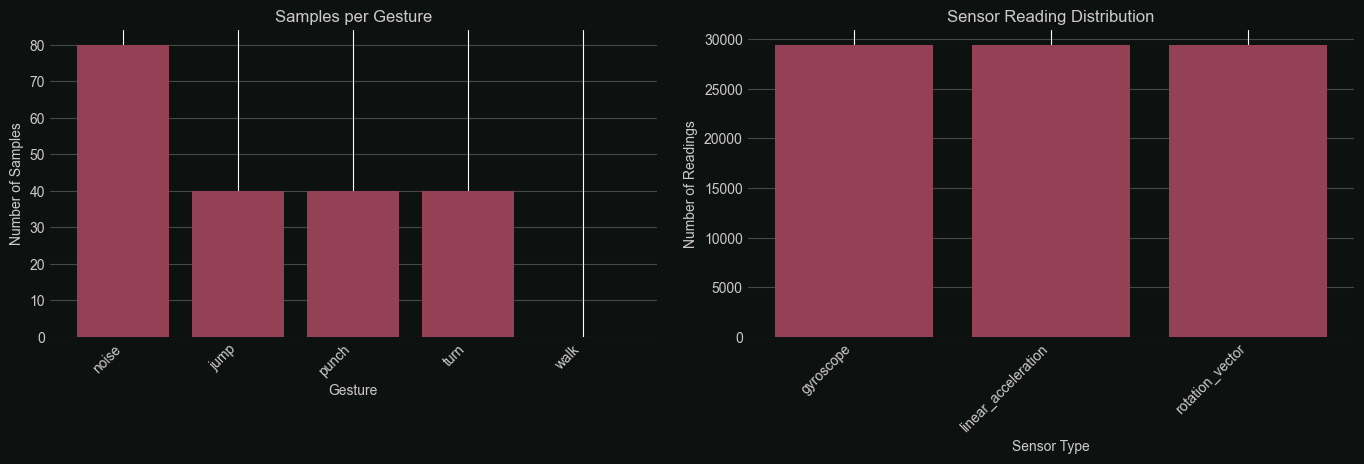

In [5]:
# Ensure you have matplotlib imported
import matplotlib.pyplot as plt

if not all_data.empty:
    # Create figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Hornet from Hollowknight: Silksong Colors
    bar_color = "#944055"
    bg_color = "#0D1210"
    axis_color = "#CFC9CB"
    grid_alpha = 0.3

    # Set figure and axes backgrounds
    fig.patch.set_facecolor(bg_color)
    for ax in axes:
        ax.set_facecolor(bg_color)

        # Axis spine and tick colors
        for spine in ax.spines.values():
            spine.set_color(axis_color)

        ax.tick_params(colors=axis_color)  # tick labels and ticks
        ax.xaxis.label.set_color(axis_color)
        ax.yaxis.label.set_color(axis_color)
        ax.title.set_color(axis_color)

        # Grid color
        ax.grid(axis="y", alpha=grid_alpha, color=axis_color)

    # Gesture distribution
    gesture_samples = (
        all_data.groupby("gesture")["sample"].nunique().sort_values(ascending=False)
    )
    axes[0].bar(range(len(gesture_samples)), gesture_samples.values, color=bar_color)
    axes[0].set_xticks(range(len(gesture_samples)))
    axes[0].set_xticklabels(gesture_samples.index, rotation=45, ha="right")
    axes[0].set_xlabel("Gesture")
    axes[0].set_ylabel("Number of Samples")
    axes[0].set_title("Samples per Gesture")

    # Sensor distribution
    sensor_counts = all_data["sensor"].value_counts()
    axes[1].bar(range(len(sensor_counts)), sensor_counts.values, color=bar_color)
    axes[1].set_xticks(range(len(sensor_counts)))
    axes[1].set_xticklabels(sensor_counts.index, rotation=45, ha="right")
    axes[1].set_xlabel("Sensor Type")
    axes[1].set_ylabel("Number of Readings")
    axes[1].set_title("Sensor Reading Distribution")

    # Tight layout on dark background can clip labels; add pad and use constrained layout
    plt.tight_layout(pad=2.0)
    plt.show()

## 3. Feature Engineering

### 3.1 Feature Extraction Strategy

We extract features from time windows of sensor data. For each gesture sample (3 seconds of recording), we compute:

**Time-Domain Features:**
- Statistical moments: mean, std, min, max, range
- Distribution shape: skewness, kurtosis
- Peak detection: number of peaks above threshold

**Frequency-Domain Features:**
- FFT magnitude spectrum
- Dominant frequency components
- Spectral energy

**Per-Sensor Features:**
- Acceleration (x, y, z): 10 features per axis = 30 features
- Gyroscope (x, y, z): 8 features per axis = 24 features
- Rotation (quaternion): 8 features = 8 features

**Total: ~60+ features per gesture sample**

In [6]:
def extract_window_features(window_df):
    """Extract comprehensive features from a time window of sensor data.

    Parameters:
    -----------
    window_df : pd.DataFrame
        DataFrame containing sensor readings for a single gesture sample

    Returns:
    --------
    dict
        Dictionary of extracted features
    """
    features = {}

    # Separate by sensor type
    accel = window_df[window_df["sensor"] == "linear_acceleration"]
    gyro = window_df[window_df["sensor"] == "gyroscope"]
    rot = window_df[window_df["sensor"] == "rotation_vector"]

    # ========== ACCELERATION FEATURES ==========
    if len(accel) > 0:
        for axis in ["accel_x", "accel_y", "accel_z"]:
            values = accel[axis].dropna()

            if len(values) > 0:
                # Time-domain statistics
                features[f"{axis}_mean"] = values.mean()
                features[f"{axis}_std"] = values.std()
                features[f"{axis}_max"] = values.max()
                features[f"{axis}_min"] = values.min()
                features[f"{axis}_range"] = values.max() - values.min()
                features[f"{axis}_median"] = values.median()

                # Distribution shape
                features[f"{axis}_skew"] = stats.skew(values)
                features[f"{axis}_kurtosis"] = stats.kurtosis(values)

                # Peak detection
                threshold = values.mean() + 2 * values.std()
                features[f"{axis}_peak_count"] = len(values[values > threshold])

                # Frequency domain (FFT)
                if len(values) > 2:
                    fft_vals = np.abs(fft(values))[: len(values) // 2]
                    if len(fft_vals) > 0:
                        features[f"{axis}_fft_max"] = fft_vals.max()
                        features[f"{axis}_dominant_freq"] = fft_vals.argmax()
                        features[f"{axis}_fft_mean"] = fft_vals.mean()

    # ========== GYROSCOPE FEATURES ==========
    if len(gyro) > 0:
        for axis in ["gyro_x", "gyro_y", "gyro_z"]:
            values = gyro[axis].dropna()

            if len(values) > 0:
                # Time-domain statistics
                features[f"{axis}_mean"] = values.mean()
                features[f"{axis}_std"] = values.std()
                features[f"{axis}_max_abs"] = values.abs().max()
                features[f"{axis}_range"] = values.max() - values.min()

                # Distribution shape
                features[f"{axis}_skew"] = stats.skew(values)
                features[f"{axis}_kurtosis"] = stats.kurtosis(values)

                # RMS (root mean square)
                features[f"{axis}_rms"] = np.sqrt(np.mean(values**2))

                # Frequency domain
                if len(values) > 2:
                    fft_vals = np.abs(fft(values))[: len(values) // 2]
                    if len(fft_vals) > 0:
                        features[f"{axis}_fft_max"] = fft_vals.max()

    # ========== ROTATION FEATURES ==========
    if len(rot) > 0:
        for axis in ["rot_x", "rot_y", "rot_z", "rot_w"]:
            values = rot[axis].dropna()

            if len(values) > 0:
                features[f"{axis}_mean"] = values.mean()
                features[f"{axis}_std"] = values.std()
                features[f"{axis}_range"] = values.max() - values.min()

    # ========== CROSS-SENSOR FEATURES ==========
    # Acceleration magnitude
    if len(accel) > 0:
        accel_mag = np.sqrt(
            accel["accel_x"].fillna(0) ** 2
            + accel["accel_y"].fillna(0) ** 2
            + accel["accel_z"].fillna(0) ** 2
        )
        features["accel_magnitude_mean"] = accel_mag.mean()
        features["accel_magnitude_max"] = accel_mag.max()
        features["accel_magnitude_std"] = accel_mag.std()

    # Gyroscope magnitude
    if len(gyro) > 0:
        gyro_mag = np.sqrt(
            gyro["gyro_x"].fillna(0) ** 2
            + gyro["gyro_y"].fillna(0) ** 2
            + gyro["gyro_z"].fillna(0) ** 2
        )
        features["gyro_magnitude_mean"] = gyro_mag.mean()
        features["gyro_magnitude_max"] = gyro_mag.max()
        features["gyro_magnitude_std"] = gyro_mag.std()

    return features

### 3.2 Apply Feature Extraction

In [7]:
if not all_data.empty:
    print("=" * 60)
    print("EXTRACTING FEATURES (HYBRID APPROACH)")
    print("=" * 60)

    features_list = []
    labels_list = []

    # Define sliding window parameters for continuous data
    WINDOW_SIZE_SEC = 2.5  # Should match your atomic gesture recording duration
    STRIDE_SEC = 0.2  # How much to slide the window forward each time (creates overlap)

    total_samples = 0

    # Group data by the source file, which represents a single recording
    for source_file, group in all_data.groupby("source_file"):
        gesture_label = group["gesture"].iloc[0]

        # --- SPECIAL CASE for continuous gestures ---
        if "continuous" in source_file:
            print(
                f"  Processing continuous file '{source_file}' with sliding window..."
            )

            # Calculate window size and stride in terms of number of readings
            # This is an approximation; a more robust way would use timestamps.
            approx_hz = len(group) / group["timestamp"].max()
            window_size_samples = int(WINDOW_SIZE_SEC * approx_hz)
            stride_samples = int(STRIDE_SEC * approx_hz)

            generated_samples = 0
            for start in range(0, len(group) - window_size_samples, stride_samples):
                end = start + window_size_samples
                window_df = group.iloc[start:end]

                # Skip windows with no data (unlikely but safe)
                if window_df.empty:
                    continue

                features = extract_window_features(window_df)
                features_list.append(features)
                labels_list.append(gesture_label)
                generated_samples += 1

            print(f"    → Generated {generated_samples} '{gesture_label}' samples.")
            total_samples += generated_samples

        # --- STANDARD CASE for atomic, snippet-based gestures ---
        else:
            features = extract_window_features(group)
            features_list.append(features)
            labels_list.append(gesture_label)
            total_samples += 1

    # Create final feature matrix
    X = pd.DataFrame(features_list).fillna(0)
    y = pd.Series(labels_list)

    print(f"\n✓ Feature extraction complete!")
    print(f"  Processed samples: {total_samples}")  # This will be much larger now
    print(f"  Feature matrix shape: {X.shape}")
    print(f"  Number of features: {X.shape[1]}")
    print(f"  Number of classes: {y.nunique()}")

    print("\n--- NEW Class Distribution ---")
    class_dist = y.value_counts().sort_index()
    for label, count in class_dist.items():
        print(f"  {label}: {count} samples")

    print("\n--- Sample Features (first 10) ---")
    display(X.head(10))

EXTRACTING FEATURES (HYBRID APPROACH)
  Processing continuous file 'walk_continuous.csv' with sliding window...
    → Generated 759 'walk' samples.

✓ Feature extraction complete!
  Processed samples: 959
  Feature matrix shape: (959, 78)
  Number of features: 78
  Number of classes: 5

--- NEW Class Distribution ---
  jump: 40 samples
  noise: 80 samples
  punch: 40 samples
  turn: 40 samples
  walk: 759 samples

--- Sample Features (first 10) ---


,accel_x_mean,accel_x_std,accel_x_max,accel_x_min,accel_x_range,accel_x_median,accel_x_skew,accel_x_kurtosis,accel_x_peak_count,accel_x_fft_max,accel_x_dominant_freq,accel_x_fft_mean,accel_y_mean,accel_y_std,accel_y_max,accel_y_min,accel_y_range,accel_y_median,accel_y_skew,accel_y_kurtosis,accel_y_peak_count,accel_y_fft_max,accel_y_dominant_freq,accel_y_fft_mean,accel_z_mean,accel_z_std,accel_z_max,accel_z_min,accel_z_range,accel_z_median,accel_z_skew,accel_z_kurtosis,accel_z_peak_count,accel_z_fft_max,accel_z_dominant_freq,accel_z_fft_mean,gyro_x_mean,gyro_x_std,gyro_x_max_abs,gyro_x_range,gyro_x_skew,gyro_x_kurtosis,gyro_x_rms,gyro_x_fft_max,gyro_y_mean,gyro_y_std,gyro_y_max_abs,gyro_y_range,gyro_y_skew,gyro_y_kurtosis,gyro_y_rms,gyro_y_fft_max,gyro_z_mean,gyro_z_std,gyro_z_max_abs,gyro_z_range,gyro_z_skew,gyro_z_kurtosis,gyro_z_rms,gyro_z_fft_max,rot_x_mean,rot_x_std,rot_x_range,rot_y_mean,rot_y_std,rot_y_range,rot_z_mean,rot_z_std,rot_z_range,rot_w_mean,rot_w_std,rot_w_range,accel_magnitude_mean,accel_magnitude_max,accel_magnitude_std,gyro_magnitude_mean,gyro_magnitude_max,gyro_magnitude_std
0,-3.1057,8.8385,6.8408,-49.3019,56.1427,-1.1538,-3.2979,11.7904,0,422.3790,0,80.5381,-6.1498,9.5545,2.8850,-45.6076,48.4927,-2.3998,-2.2846,5.2488,0,836.3779,0,80.3739,-2.6679,6.7673,26.9913,-21.4988,48.4901,-1.8932,1.1393,5.6450,6,362.8312,0,59.4281,0.1333,4.0057,13.5711,24.3137,0.9309,2.4953,3.9934,214.5592,0.2902,1.3516,5.4346,6.8486,1.9579,3.5556,1.3776,62.3114,-0.8077,3.1756,11.8855,19.9185,-1.6023,3.8627,3.2656,177.9100,-0.1130,0.1256,0.4919,0.2963,0.4076,1.3007,-0.5299,0.2879,0.9844,0.5526,0.2254,0.7358,10.1907,63.6764,12.8674,3.4974,17.6549,4.0492
1,-2.4713,9.5935,11.9577,-47.7252,59.6829,-1.1802,-2.3066,7.4987,0,500.2173,6,80.7138,-4.9335,13.4562,17.4364,-57.1014,74.5377,-0.4782,-2.3147,5.3864,0,725.2189,0,119.1433,-3.9420,6.5514,4.6398,-21.0492,25.6890,-1.3475,-1.2326,0.3211,0,579.4681,0,47.5980,-0.3006,3.0230,11.9618,21.4776,-0.4567,4.4671,3.0276,158.5352,0.2555,1.8772,7.5821,10.8093,1.5479,3.3801,1.8882,102.9116,-0.5170,3.6093,15.2310,25.4406,-1.2602,5.6026,3.6340,169.1181,-0.3122,0.1360,0.6608,0.4353,0.2320,0.8587,-0.4856,0.3217,1.1045,0.5185,0.1846,0.5681,12.2463,70.4539,14.5371,3.3127,17.9584,3.8814
2,-2.4327,11.4097,13.0656,-70.5152,83.5808,-0.4474,-3.2550,13.6881,0,372.2032,0,124.6904,-6.2571,13.0339,3.0439,-66.2072,69.2511,-2.9786,-3.0485,9.0877,0,957.3313,0,136.9611,-3.1411,6.2283,10.0488,-20.4493,30.4980,-1.2753,-1.1732,0.6620,2,480.5813,0,55.2155,0.0563,3.5834,14.3617,28.1896,0.1867,5.2339,3.5720,230.1992,-0.1413,0.8784,2.2489,4.3443,0.3074,-0.1357,0.8868,46.8137,-0.3029,3.4196,14.6244,25.3431,-1.1988,5.8729,3.4217,216.6378,-0.2123,0.1272,0.5363,0.4000,0.2771,0.9261,-0.5187,0.2991,0.9792,0.5712,0.1362,0.4354,11.5220,86.2874,16.1407,3.3140,19.0988,3.7902
3,-1.0096,9.2199,16.8589,-53.6025,70.4614,0.2825,-3.6276,16.3907,0,300.9135,9,93.3612,-4.6694,11.9452,4.5729,-74.7925,79.3653,-0.8415,-3.7765,16.3586,0,714.4150,0,100.8715,-2.4920,8.5692,23.6601,-31.0992,54.7594,-0.5221,-1.0661,3.1247,4,403.0246,3,72.7083,0.2100,2.9554,12.6904,18.6270,2.0729,6.1516,2.9532,148.7205,0.2494,1.1868,4.8884,6.8799,1.5949,4.0604,1.2089,64.9350,-0.4516,2.8097,12.9968,18.2261,-2.2696,7.1579,2.8367,160.3174,-0.1081,0.1152,0.4875,0.3153,0.2469,0.8680,-0.5314,0.4013,1.1972,0.5921,0.1494,0.5256,10.2126,80.6385,15.0122,2.7181,18.2408,3.3034
4,0.6272,9.5597,13.6065,-48.3681,61.9746,1.5482,-3.0310,11.4503,0,370.2076,1,77.3942,-6.7029,10.3245,1.9292,-56.7754,58.7046,-3.3628,-2.8234,8.2646,0,924.9971,0,100.7998,-1.7756,8.2223,21.5345,-17.3557,38.8901,-0.1733,0.0505,0.6565,6,382.2993,2,62.6010,-0.3565,3.8522,12.7617,25.1095,0.4904,4.0317,3.8544,183.9826,0.1042,1.4504,5.3884,7.8223,1.3466,2.5353,1.4488,65.1557,-0.2215,2.3940,9.0871,15.8469,-0.7796,4.6587,2.3953,141.6783,-0.0729,0.1495,0.4981,0.5013,0.2490,0.9161,-0.3092,0.3334,1.0316,0.6548,0.1582,0.4571,12.2342,66.2845,12.7926,3.0923,16.4687,3.6371
5,-4.5453,11.7172,12.9367,-47.1267,60.0634,-2.0981,-

## 4. Model Training

### 4.1 Train-Test Split

We use stratified splitting to ensure balanced class representation in both sets.

In [8]:
if not all_data.empty and "X" in locals():
    print("=" * 60)
    print("PREPARING TRAINING AND TEST SETS")
    print("=" * 60)

    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=RANDOM_SEED,
        stratify=y,  # Maintain class distribution
    )

    print(f"\nTraining set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    print("\n--- Training Set Distribution ---")
    train_dist = y_train.value_counts().sort_index()
    for label, count in train_dist.items():
        print(f"  {label}: {count} samples")

    print("\n--- Test Set Distribution ---")
    test_dist = y_test.value_counts().sort_index()
    for label, count in test_dist.items():
        print(f"  {label}: {count} samples")

PREPARING TRAINING AND TEST SETS

Training set: 767 samples
Test set: 192 samples

--- Training Set Distribution ---
  jump: 32 samples
  noise: 64 samples
  punch: 32 samples
  turn: 32 samples
  walk: 607 samples

--- Test Set Distribution ---
  jump: 8 samples
  noise: 16 samples
  punch: 8 samples
  turn: 8 samples
  walk: 152 samples


### 4.2 Feature Scaling

Normalize features using StandardScaler for optimal SVM performance.

In [9]:
if not all_data.empty and "X_train" in locals():
    print("=" * 60)
    print("SCALING FEATURES")
    print("=" * 60)

    # Initialize scaler
    scaler = StandardScaler()

    # Fit on training data and transform both sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("\n✓ Features scaled using StandardScaler")
    print(f"  Mean of scaled features: {X_train_scaled.mean():.6f}")
    print(f"  Std of scaled features: {X_train_scaled.std():.6f}")

SCALING FEATURES

✓ Features scaled using StandardScaler
  Mean of scaled features: -0.000000
  Std of scaled features: 1.000000


### 4.3 Model Training - Support Vector Machine

**Model Choice: SVM with RBF Kernel**

Advantages:
- Excellent for high-dimensional feature spaces
- Non-linear decision boundaries via RBF kernel
- Strong theoretical foundations
- Good generalization with proper hyperparameter tuning

**Hyperparameter Tuning:**
- `C`: Regularization parameter
- `gamma`: Kernel coefficient

In [10]:
if not all_data.empty and "X_train_scaled" in locals():
    print("=" * 60)
    print("TRAINING SVM MODEL WITH HYPERPARAMETER TUNING")
    print("=" * 60)

    # Define parameter grid for GridSearchCV
    param_grid = {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
        "kernel": ["rbf"],
    }

    print("\nSearching optimal hyperparameters...")
    print(f"Parameter grid: {param_grid}")
    print(f"Total combinations: {len(param_grid['C']) * len(param_grid['gamma'])}")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        SVC(random_state=RANDOM_SEED, probability=True),  # Enable probability estimates
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="accuracy",
        n_jobs=-1,  # Use all available cores
        verbose=1,
    )

    # Perform grid search
    grid_search.fit(X_train_scaled, y_train)

    # Get best model
    svm_model = grid_search.best_estimator_

    print("\n" + "=" * 60)
    print("GRID SEARCH RESULTS")
    print("=" * 60)
    print(f"\n✓ Best parameters: {grid_search.best_params_}")
    print(f"✓ Best cross-validation score: {grid_search.best_score_:.4f}")

    # Show top 5 parameter combinations
    print("\n--- Top 5 Parameter Combinations ---")
    results_df = pd.DataFrame(grid_search.cv_results_)
    top_results = results_df.nlargest(5, "mean_test_score")[
        ["params", "mean_test_score", "std_test_score"]
    ]
    for idx, row in top_results.iterrows():
        print(f"  {row['params']}")
        print(
            f"    Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})"
        )

TRAINING SVM MODEL WITH HYPERPARAMETER TUNING

Searching optimal hyperparameters...
Parameter grid: {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1], 'kernel': ['rbf']}
Total combinations: 20
Fitting 5 folds for each of 20 candidates, totalling 100 fits

GRID SEARCH RESULTS

✓ Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
✓ Best cross-validation score: 0.9635

--- Top 5 Parameter Combinations ---
  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
    Score: 0.9635 (+/- 0.0107)
  {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
    Score: 0.9622 (+/- 0.0097)
  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
    Score: 0.9596 (+/- 0.0077)
  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Score: 0.9596 (+/- 0.0077)
  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
    Score: 0.9583 (+/- 0.0135)


### 4.4 Alternative Model - Random Forest

For comparison, we also train a Random Forest classifier.

In [11]:
if not all_data.empty and "X_train_scaled" in locals():
    print("=" * 60)
    print("TRAINING RANDOM FOREST MODEL (FOR COMPARISON)")
    print("=" * 60)

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=RANDOM_SEED, n_jobs=-1
    )

    rf_model.fit(X_train_scaled, y_train)

    print("\n✓ Random Forest trained")

    # Feature importance
    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("\n--- Top 10 Most Important Features ---")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

TRAINING RANDOM FOREST MODEL (FOR COMPARISON)

✓ Random Forest trained

--- Top 10 Most Important Features ---
  rot_x_mean: 0.0782
  rot_w_std: 0.0552
  rot_w_mean: 0.0497
  gyro_z_fft_max: 0.0491
  accel_x_median: 0.0489
  rot_z_mean: 0.0476
  accel_y_fft_max: 0.0449
  rot_w_range: 0.0412
  gyro_z_kurtosis: 0.0310
  accel_x_max: 0.0240


## 5. Model Evaluation

### 5.1 Performance on Test Set

SVM MODEL EVALUATION

Test Set Accuracy: 0.9583
Test Set F1-Score (weighted): 0.9465

--- Classification Report ---
              precision    recall  f1-score   support

        jump       1.00      0.12      0.22         8
       noise       0.75      0.94      0.83        16
       punch       1.00      1.00      1.00         8
        turn       0.80      1.00      0.89         8
        walk       0.99      1.00      1.00       152

    accuracy                           0.96       192
   macro avg       0.91      0.81      0.79       192
weighted avg       0.97      0.96      0.95       192


--- Confusion Matrix ---


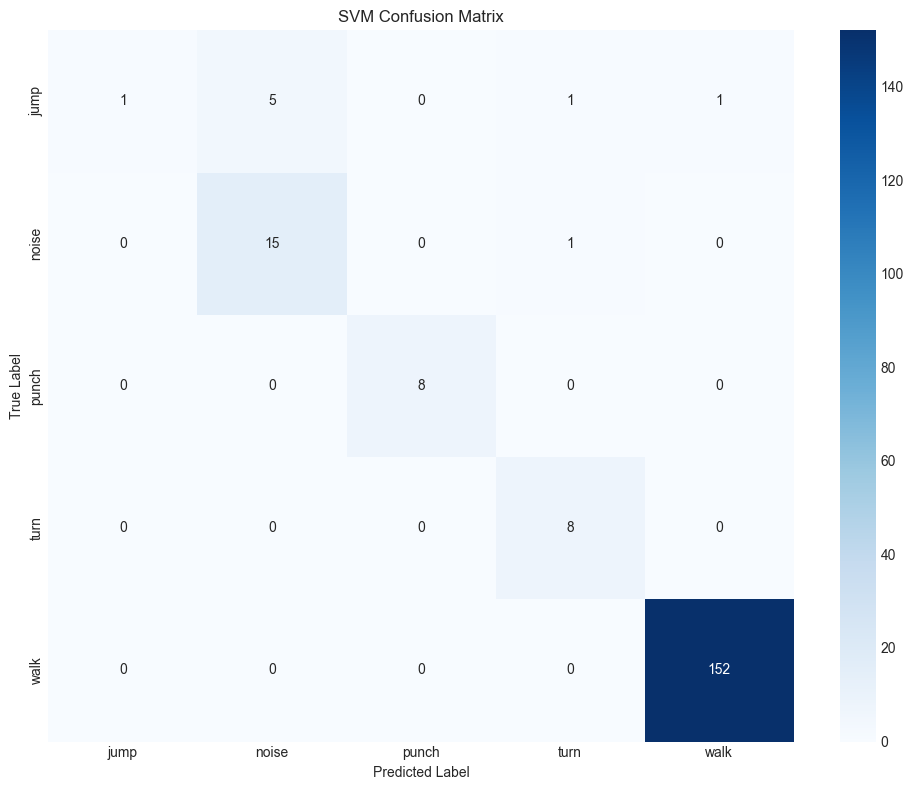

In [12]:
if not all_data.empty and "svm_model" in locals():
    print("=" * 60)
    print("SVM MODEL EVALUATION")
    print("=" * 60)

    # Predictions
    y_pred_svm = svm_model.predict(X_test_scaled)
    y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)

    # Calculate metrics
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    f1_svm = f1_score(y_test, y_pred_svm, average="weighted")

    print(f"\nTest Set Accuracy: {accuracy_svm:.4f}")
    print(f"Test Set F1-Score (weighted): {f1_svm:.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_svm))

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred_svm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=sorted(y.unique()),
        yticklabels=sorted(y.unique()),
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("SVM Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [13]:
if not all_data.empty and "rf_model" in locals():
    print("=" * 60)
    print("RANDOM FOREST MODEL EVALUATION")
    print("=" * 60)

    # Predictions
    y_pred_rf = rf_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    f1_rf = f1_score(y_test, y_pred_rf, average="weighted")

    print(f"\nTest Set Accuracy: {accuracy_rf:.4f}")
    print(f"Test Set F1-Score (weighted): {f1_rf:.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_rf))

RANDOM FOREST MODEL EVALUATION

Test Set Accuracy: 0.9531
Test Set F1-Score (weighted): 0.9504

--- Classification Report ---
              precision    recall  f1-score   support

        jump       1.00      0.38      0.55         8
       noise       0.67      0.88      0.76        16
       punch       1.00      1.00      1.00         8
        turn       0.75      0.75      0.75         8
        walk       1.00      1.00      1.00       152

    accuracy                           0.95       192
   macro avg       0.88      0.80      0.81       192
weighted avg       0.96      0.95      0.95       192



### 5.2 Cross-Validation

Perform additional cross-validation on the full dataset to validate model robustness.

In [14]:
if not all_data.empty and "svm_model" in locals():
    print("=" * 60)
    print("CROSS-VALIDATION ANALYSIS")
    print("=" * 60)

    # Scale all data
    X_all_scaled = scaler.fit_transform(X)

    # Perform cross-validation with best SVM model
    cv_scores = cross_val_score(svm_model, X_all_scaled, y, cv=5, scoring="accuracy")

    print(f"\n5-Fold Cross-Validation Results:")
    print(f"  Scores: {cv_scores}")
    print(f"  Mean accuracy: {cv_scores.mean():.4f}")
    print(f"  Std deviation: {cv_scores.std():.4f}")
    print(
        f"  95% confidence interval: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]"
    )

CROSS-VALIDATION ANALYSIS

5-Fold Cross-Validation Results:
  Scores: [0.96354167 0.96354167 0.96354167 0.94791667 0.95811518]
  Mean accuracy: 0.9593
  Std deviation: 0.0061
  95% confidence interval: [0.9474, 0.9713]


### 5.3 Model Comparison

MODEL COMPARISON SUMMARY




,Model,Accuracy,F1-Score
0,SVM (RBF),0.9583,0.9465
1,Random Forest,0.9531,0.9504


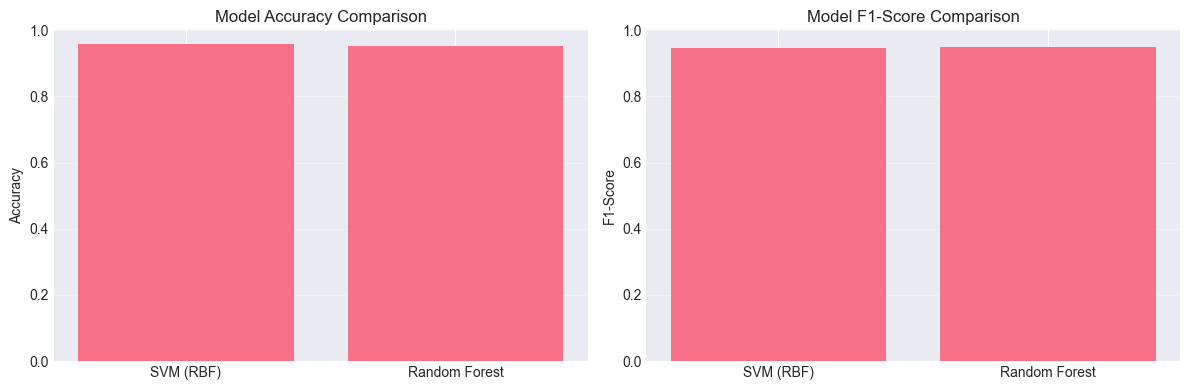


✓ Best performing model: SVM


In [15]:
if not all_data.empty and "svm_model" in locals() and "rf_model" in locals():
    print("=" * 60)
    print("MODEL COMPARISON SUMMARY")
    print("=" * 60)

    comparison_df = pd.DataFrame(
        {
            "Model": ["SVM (RBF)", "Random Forest"],
            "Accuracy": [accuracy_svm, accuracy_rf],
            "F1-Score": [f1_svm, f1_rf],
        }
    )

    print("\n")
    display(comparison_df)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy comparison
    axes[0].bar(comparison_df["Model"], comparison_df["Accuracy"])
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Model Accuracy Comparison")
    axes[0].set_ylim([0, 1.0])
    axes[0].grid(axis="y", alpha=0.3)

    # F1-Score comparison
    axes[1].bar(comparison_df["Model"], comparison_df["F1-Score"])
    axes[1].set_ylabel("F1-Score")
    axes[1].set_title("Model F1-Score Comparison")
    axes[1].set_ylim([0, 1.0])
    axes[1].grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Determine best model
    best_model_name = "SVM" if accuracy_svm >= accuracy_rf else "Random Forest"
    best_model = svm_model if accuracy_svm >= accuracy_rf else rf_model

    print(f"\n✓ Best performing model: {best_model_name}")

## 6. Model Serialization

Save the trained model and scaler for deployment in the real-time controller.

In [16]:
if not all_data.empty and "svm_model" in locals():
    print("=" * 60)
    print("SAVING MODELS FOR DEPLOYMENT")
    print("=" * 60)

    # Create models directory if it doesn't exist
    os.makedirs("models", exist_ok=True)

    # Save SVM model
    model_path = "models/gesture_classifier.pkl"
    joblib.dump(svm_model, model_path)
    print(f"\n✓ Model saved: {model_path}")
    print(f"  File size: {os.path.getsize(model_path) / 1024:.2f} KB")

    # Save scaler
    scaler_path = "models/feature_scaler.pkl"
    joblib.dump(scaler, scaler_path)
    print(f"\n✓ Scaler saved: {scaler_path}")
    print(f"  File size: {os.path.getsize(scaler_path) / 1024:.2f} KB")

    # Save feature names for reference
    feature_names_path = "models/feature_names.pkl"
    joblib.dump(X.columns.tolist(), feature_names_path)
    print(f"\n✓ Feature names saved: {feature_names_path}")

    # Save Random Forest as alternative
    if "rf_model" in locals():
        rf_path = "models/random_forest_classifier.pkl"
        joblib.dump(rf_model, rf_path)
        print(f"\n✓ Random Forest saved: {rf_path}")
        print(f"  File size: {os.path.getsize(rf_path) / 1024:.2f} KB")

    # Save model metadata
    metadata = {
        "model_type": "SVM",
        "kernel": "rbf",
        "best_params": grid_search.best_params_,
        "test_accuracy": accuracy_svm,
        "test_f1_score": f1_svm,
        "cv_mean_score": cv_scores.mean(),
        "cv_std_score": cv_scores.std(),
        "num_features": X.shape[1],
        "num_classes": y.nunique(),
        "classes": sorted(y.unique()),
        "training_samples": len(y),
        "training_date": pd.Timestamp.now().isoformat(),
    }

    metadata_path = "models/model_metadata.json"
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)
    print(f"\n✓ Model metadata saved: {metadata_path}")

    print("\n" + "=" * 60)
    print("✓ ALL MODELS SAVED SUCCESSFULLY!")
    print("=" * 60)
    print("\nNext Steps:")
    print("1. Models are ready for deployment")
    print("2. Update src/udp_listener.py to load these models")
    print("3. Implement real-time gesture prediction")
    print("4. Test with live sensor data from the smartwatch")

SAVING MODELS FOR DEPLOYMENT

✓ Model saved: models/gesture_classifier.pkl
  File size: 93.34 KB

✓ Scaler saved: models/feature_scaler.pkl
  File size: 3.91 KB

✓ Feature names saved: models/feature_names.pkl

✓ Random Forest saved: models/random_forest_classifier.pkl
  File size: 609.53 KB

✓ Model metadata saved: models/model_metadata.json

✓ ALL MODELS SAVED SUCCESSFULLY!

Next Steps:
1. Models are ready for deployment
2. Update src/udp_listener.py to load these models
3. Implement real-time gesture prediction
4. Test with live sensor data from the smartwatch


## 7. Model Validation

Test model loading and prediction to ensure deployment readiness.

In [17]:
if not all_data.empty and os.path.exists("models/gesture_classifier.pkl"):
    print("=" * 60)
    print("VALIDATING MODEL DEPLOYMENT")
    print("=" * 60)

    # Load saved model and scaler
    loaded_model = joblib.load("models/gesture_classifier.pkl")
    loaded_scaler = joblib.load("models/feature_scaler.pkl")
    loaded_features = joblib.load("models/feature_names.pkl")

    print("\n✓ Models loaded successfully")

    # Test prediction on a sample
    test_sample = X_test.iloc[0:1]
    test_sample_scaled = loaded_scaler.transform(test_sample)

    prediction = loaded_model.predict(test_sample_scaled)
    confidence = loaded_model.predict_proba(test_sample_scaled).max()

    print("\n--- Test Prediction ---")
    print(f"  Predicted gesture: {prediction[0]}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Actual gesture: {y_test.iloc[0]}")
    print(f"  Correct: {'✓' if prediction[0] == y_test.iloc[0] else '✗'}")

    # Verify feature names match
    if loaded_features == X.columns.tolist():
        print("\n✓ Feature names match")
    else:
        print("\n⚠️  Feature name mismatch detected")

    print("\n" + "=" * 60)
    print("✓ MODEL VALIDATION SUCCESSFUL")
    print("=" * 60)

VALIDATING MODEL DEPLOYMENT

✓ Models loaded successfully

--- Test Prediction ---
  Predicted gesture: walk
  Confidence: 0.9881
  Actual gesture: walk
  Correct: ✓

✓ Feature names match

✓ MODEL VALIDATION SUCCESSFUL


## 8. Summary and Next Steps

### Pipeline Summary

This notebook has completed the following:

1. ✓ **Data Loading** - Loaded and validated IMU sensor data
2. ✓ **Feature Engineering** - Extracted 60+ features from time-series data
3. ✓ **Model Training** - Trained SVM and Random Forest classifiers
4. ✓ **Hyperparameter Tuning** - Optimized model parameters via GridSearchCV
5. ✓ **Model Evaluation** - Validated performance on test set
6. ✓ **Model Serialization** - Saved models for deployment

### Performance Expectations

- **Target Accuracy**: >85% on test set
- **Real-time Latency**: <100ms per prediction
- **Confidence Threshold**: 0.7 (70%) for gesture execution

### Phase IV: Real-Time Deployment

To integrate this model into the game controller:

1. **Update `src/udp_listener.py`**:
   ```python
   import joblib
   from collections import deque
   
   # Load models
   model = joblib.load('models/gesture_classifier.pkl')
   scaler = joblib.load('models/feature_scaler.pkl')
   
   # Create buffer for sensor data
   sensor_buffer = deque(maxlen=150)  # ~3 seconds at 50Hz
   ```

2. **Implement prediction logic**:
   - Collect sensor data in a sliding window
   - Extract features using `extract_window_features()`
   - Scale features using loaded scaler
   - Predict gesture with confidence threshold
   - Execute corresponding keyboard action

3. **Test with live data**:
   - Run data collector to stream sensor data
   - Verify real-time predictions
   - Tune confidence thresholds for responsiveness

### Watson Preferred Checklist

- [x] Clear problem statement and objectives
- [x] Data loading and exploration
- [x] Feature engineering with justification
- [x] Model selection with rationale
- [x] Hyperparameter tuning methodology
- [x] Comprehensive evaluation metrics
- [x] Model serialization for deployment
- [x] Validation and testing
- [x] Documentation and next steps

---

**End of ML Pipeline Notebook**